### Đọc data từ CSV

In [ ]:
import pandas as pd
df = pd.read_csv("./2019-Oct.csv")

In [ ]:
df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [ ]:
purchase_df = df[df['event_type'] == 'purchase']

In [4]:
purchase_df.count()

event_time       742849
event_type       742849
product_id       742849
category_id      742849
category_code    569424
brand            684544
price            742849
user_id          742849
user_session     742849
dtype: int64

In [5]:
purchase_df = purchase_df.fillna("unknown")

In [6]:
# DataFrame after replacing null values
purchase_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
162,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
308,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
379,2019-10-01 00:06:02 UTC,purchase,5100816,2053013553375346967,unknown,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
442,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
574,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553


In [ ]:
# import pyarrow.parquet as pq
# import pyarrow as pa
# import pandas as pd
# import glob

# path = "./data/*.parquet"
# files = sorted(glob.glob(path))
# print("Found files:", len(files))

# # accumulate filtered frames
# purchase_frames = []
# for i, f in enumerate(files):
#     print(f"Reading {i+1}/{len(files)}: {f}")
#     tmp = pq.read_table(f) 
#     df = tmp.to_pandas(ignore_metadata=True)       

#     df = df[df['event_type'] == 'purchase'].copy()

#     purchase_frames.append(df)
    
# purchase_df = pd.concat(purchase_frames, ignore_index=True)
# print("Total purchase rows:", purchase_df.shape[0])
# del purchase_frames

### Chuẩn hóa nhanh & lọc session có >= 2 sản phẩm

In [10]:
purchase_df['event_time'] = pd.to_datetime(purchase_df['event_time'])
purchase_df['product_id'] = purchase_df['product_id'].astype(str)  # cho mlxtend
# Lọc session có >=2 sản phẩm
session_counts = purchase_df.groupby("user_session")["product_id"].nunique()
valid_sessions = session_counts[session_counts > 1].index
purchase_df = purchase_df[purchase_df['user_session'].isin(valid_sessions)].copy()
print("After session>=2 filter:", purchase_df.shape)


After session>=2 filter: (121990, 9)


### Tạo sample 

In [8]:
N_SESSIONS = 60000   # thay nếu RAM ít/ nhiều
unique_sessions = purchase_df['user_session'].unique()
sample_sessions = unique_sessions[:N_SESSIONS]
sample_df = purchase_df[purchase_df['user_session'].isin(sample_sessions)].copy()
print("Sample rows:", sample_df.shape)


Sample rows: (121990, 9)


In [9]:
### Giới hạn số sản phẩm (giảm chiều): chọn top K sản phẩm bán chạy nhất:
TOP_K = 500   # thử 300-500
top_products = sample_df['product_id'].value_counts().head(TOP_K).index
filtered_df = sample_df[sample_df['product_id'].isin(top_products)].copy()

### Ma trận Product Transaction

In [10]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

df_for_fpgrowth = filtered_df  # hoặc sample_df nếu không lọc top K

basket = (df_for_fpgrowth
          .groupby(['user_session', 'product_id'])['event_type']
          .count()
          .unstack(fill_value=0))

basket = (basket > 0).astype(bool)
print("Basket shape:", basket.shape)

MIN_SUPPORT = 0.001  # điều chỉnh: 0.001, 0.003,...
freq_itemsets = fpgrowth(basket, min_support=MIN_SUPPORT, use_colnames=True)
print("Frequent itemsets:", freq_itemsets.shape[0])

rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.2)
rules = rules.sort_values('confidence', ascending=False).reset_index(drop=True)
print("Rules:", len(rules))
display(rules.head(10))


Basket shape: (35374, 500)
Frequent itemsets: 461
Rules: 150


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(4802036),(4804056),0.003703,0.029683,0.001470,0.396947,13.372941,1.0,0.001360,1.609007,0.928661,0.046058,0.378499,0.223235
1,(1801555),(1004767),0.004297,0.083847,0.001498,0.348684,4.158582,1.0,0.001138,1.406619,0.762811,0.017292,0.289075,0.183277
2,(1004209),(1004856),0.014530,0.103296,0.004438,0.305447,2.957006,1.0,0.002937,1.291053,0.671578,0.039142,0.225438,0.174207
3,(4804055),(4804056),0.010234,0.029683,0.002827,0.276243,9.306498,1.0,0.002523,1.340667,0.901777,0.076220,0.254103,0.185741
4,(1004833),(1004856),0.055351,0.103296,0.014700,0.265577,2.571025,1.0,0.008982,1.220964,0.646854,0.102121,0.180975,0.203943
5,"(1004856, 1004836)",(1004833),0.004721,0.055351,0.001244,0.263473,4.760008,1.0,0.000983,1.282572,0.793663,0.021144,0.220316,0.142972
6,(1004858),(1004856),0.014361,0.103296,0.003703,0.257874,2.496452,1.0,0.002220,1.208291,0.608165,0.032498,0.172384,0.146863
7,"(1004833, 1004836)",(1004856),0.005004,0.103296,0.001244,0.248588,2.406551,1.0,0.000727,1.193358,0.587407,0.011619,0.162028,0.130315
8,(1004766),(1004767),0.006587,0.083847,0.001470,0.223176,2.661708,1.0,0.000918,1.179357,0.628441,0.016524,0.152081,0.120354
9,(1004857),(1004856),0.010064,0.103296,0.002205,0.219101,2.121096,1.0,0.001165,1.148297,0.533919,0.019837,0.129145,0.120224


### Tạo dictionary 

In [11]:
from collections import defaultdict
ante_to_cons = defaultdict(set)
for _, r in rules.iterrows():
    ants = tuple(sorted(list(r['antecedents'])))
    cons = tuple(sorted(list(r['consequents'])))
    ante_to_cons[ants].update(cons)

def get_candidates_from_rules(user_items):
    user_items = set(user_items)
    cands = set()
    for ants, cons in ante_to_cons.items():
        if set(ants).issubset(user_items):
            cands.update(cons)
    return list(cands)


### Training

In [12]:
# product stats
product_pop = purchase_df['product_id'].value_counts().to_dict()
product_price = purchase_df.groupby('product_id')['price'].mean().to_dict()

# user RFM (dùng toàn purchase_df)
snapshot_date = purchase_df['event_time'].max() + pd.Timedelta(days=1)
rfm = purchase_df.groupby('user_id').agg({
    'event_time': lambda x: (snapshot_date - x.max()).days,
    'user_session': 'nunique',
    'price': 'sum'
}).rename(columns={'event_time':'Recency','user_session':'Frequency','price':'Monetary'}).fillna(0)


In [13]:
import numpy as np

rows = []
MAX_SESSIONS_FOR_TRAIN = 20000  
train_sessions = df_for_fpgrowth['user_session'].unique()[:MAX_SESSIONS_FOR_TRAIN]

for sid in train_sessions:
    grp = df_for_fpgrowth[df_for_fpgrowth['user_session']==sid]
    user = grp['user_id'].iloc[0]
    user_items = set(grp['product_id'].unique())
    # candidates từ rules
    candidates = get_candidates_from_rules(user_items)
    # positives
    for p in user_items:
        rows.append({'user_session':sid,'user_id':user,'product_id':p,'label':1,
                     'pop': product_pop.get(p,0),'price':product_price.get(p,np.nan),
                     'user_recency': rfm.loc[user,'Recency'] if user in rfm.index else np.nan,
                     'user_freq': rfm.loc[user,'Frequency'] if user in rfm.index else np.nan})
    # negatives: sample <=3 negatives from candidates not in user_items
    negs = [c for c in candidates if c not in user_items]
    if len(negs)>0:
        neg_sample = np.random.choice(negs, size=min(3,len(negs)), replace=False)
        for p in neg_sample:
            rows.append({'user_session':sid,'user_id':user,'product_id':p,'label':0,
                         'pop': product_pop.get(p,0),'price':product_price.get(p,np.nan),
                         'user_recency': rfm.loc[user,'Recency'] if user in rfm.index else np.nan,
                         'user_freq': rfm.loc[user,'Frequency'] if user in rfm.index else np.nan})

train_df = pd.DataFrame(rows).fillna(0)
print("Train rows:", train_df.shape)
train_df.head()


Train rows: (68689, 8)


,user_session,user_id,product_id,label,pop,price,user_recency,user_freq
0,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,551377651,1002532,1,137,592.811533,7,5
1,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,551377651,4804056,1,1220,160.729180,7,5
2,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,551377651,4804055,0,407,190.574767,7,5
3,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,551377651,4802036,0,143,174.521608,7,5
4,ce885079-4d92-4fe6-92a3-377c5a2d8291,555110488,1004856,1,4254,131.263874,8,2


In [15]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

features = ['pop','price','user_recency','user_freq']
X = train_df[features]
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

params = {'objective':'binary','metric':'auc','verbosity':-1,'boosting_type':'gbdt','seed':42}
model = lgb.train(
    params,
    dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dval],
    valid_names=["train", "val"],
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

pred = model.predict(X_val)
print("AUC:", roc_auc_score(y_val, pred))


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[192]	train's auc: 0.841052	val's auc: 0.813988
AUC: 0.8139880886866981


### Recommend

In [16]:
def recommend_for_user(user_id, topk=10):
    user_sessions = purchase_df[purchase_df['user_id']==user_id].sort_values('event_time', ascending=False)
    if user_sessions.empty: return []
    last_sid = user_sessions['user_session'].iloc[0]
    user_items = set(purchase_df[purchase_df['user_session']==last_sid]['product_id'].unique())
    cands = get_candidates_from_rules(user_items)
    cands = [c for c in cands if c not in user_items]
    if not cands: return []
    rows = []
    for p in cands:
        rows.append({'product_id':p,'pop':product_pop.get(p,0),'price':product_price.get(p,0),
                     'user_recency': rfm.loc[user_id,'Recency'] if user_id in rfm.index else 999,
                     'user_freq': rfm.loc[user_id,'Frequency'] if user_id in rfm.index else 0})
    Xcand = pd.DataFrame(rows)[features]
    scores = model.predict(Xcand)
    res = pd.DataFrame(rows)
    res['score'] = scores
    return res.sort_values('score', ascending=False).head(topk)['product_id'].tolist()


In [19]:
# Print out recommendation for an user
recommendations = recommend_for_user(user_id=543272936, topk=10)
print(recommendations)

['1005098', '1004767', '1004209', '1004833', '1004857', '1004858', '1004903', '1004836', '1004750', '1004834']


### Visualize

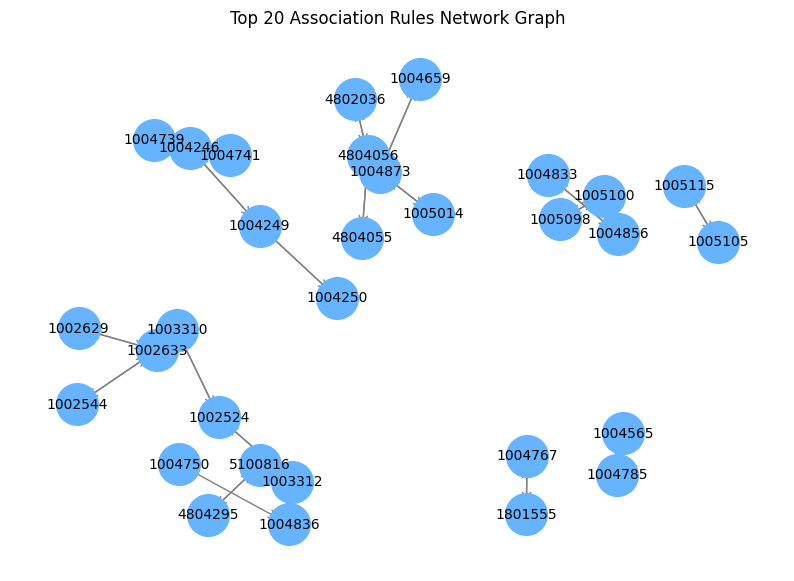

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# === LẤY 20 LUẬT MẠNH NHẤT ===
top_rules = rules.nlargest(35, 'lift')

# === TẠO GRAPH ===
G = nx.DiGraph()

for _, r in top_rules.iterrows():
    a = list(r['antecedents'])[0]
    c = list(r['consequents'])[0]
    G.add_edge(a, c, weight=r['lift'], conf=r['confidence'])

# === VẼ GRAPH ===
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.9, seed=42)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=900, node_color="#66b3ff")

# edges
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color="gray")

# labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Top 20 Association Rules Network Graph")
plt.axis("off")
plt.show()


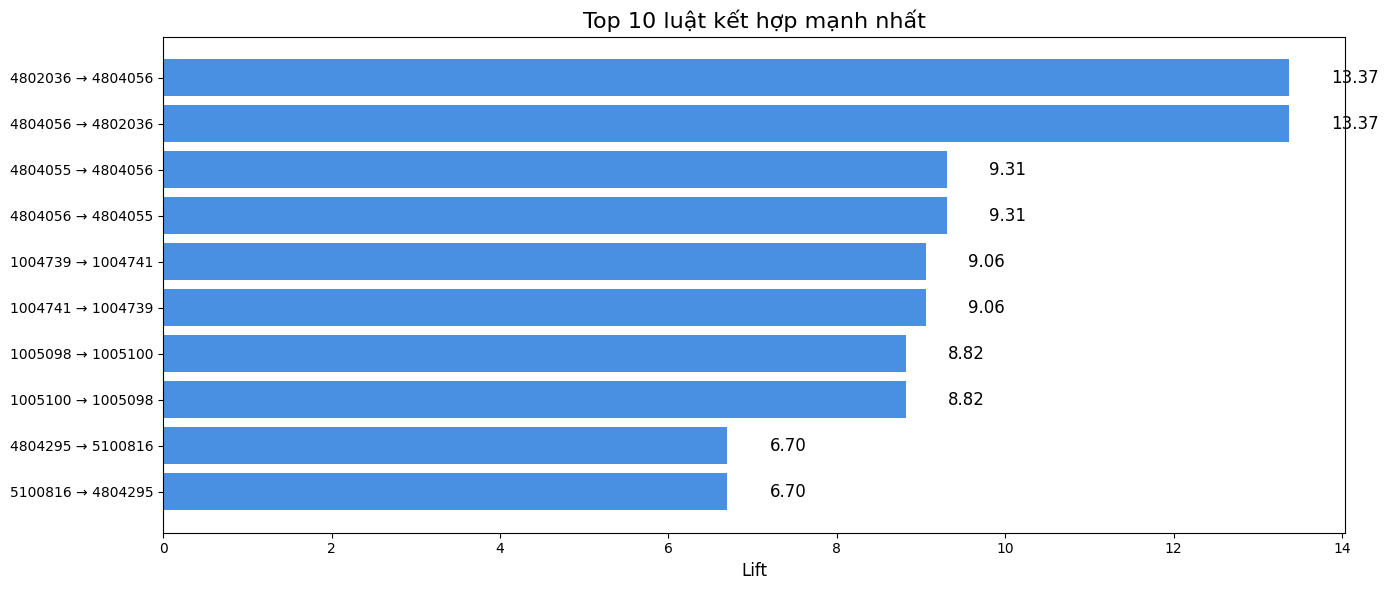

In [23]:
import matplotlib.pyplot as plt

# Lấy top 10 luật lift cao nhất
top10 = rules.nlargest(10, 'lift').copy()

# Hàm chuyển frozenset thành chuỗi "A, B, C"
def fs_to_str(fs):
    return ", ".join(list(fs))

# Tạo label dạng "A → B"
top10['label'] = top10.apply(
    lambda row: f"{fs_to_str(row['antecedents'])} → {fs_to_str(row['consequents'])}",
    axis=1
)

plt.figure(figsize=(14, 6))

plt.barh(top10['label'], top10['lift'], color="#4A90E2")

plt.xlabel("Lift", fontsize=12)
plt.title("Top 10 luật kết hợp mạnh nhất", fontsize=16)
plt.gca().invert_yaxis()  # để luật mạnh nhất nằm trên đầu

# Giá trị số trên từng thanh
for index, value in enumerate(top10['lift']):
    plt.text(value + 0.5, index, f"{value:.2f}", va='center', fontsize=12)

plt.tight_layout()
plt.show()


In [24]:
# === LẤY TOP 20 LUẬT ===
top_rules = rules.nlargest(20, 'lift')

items = sorted(list(
    set([list(a)[0] for a in top_rules['antecedents']]) |
    set([list(c)[0] for c in top_rules['consequents']])
))

# === TẠO MA TRẬN LIFT ===
lift_matrix = pd.DataFrame(0.0, index=items, columns=items, dtype=float)

for _, r in top_rules.iterrows():
    a = list(r['antecedents'])[0]
    c = list(r['consequents'])[0]
    lift_matrix.loc[a, c] = r['lift']

# === RÚT GỌN LABEL: CHỈ LẤY 4 SỐ CUỐI ===
short_rows = [str(i)[-4:] for i in lift_matrix.index]
short_cols = [str(i)[-4:] for i in lift_matrix.columns]

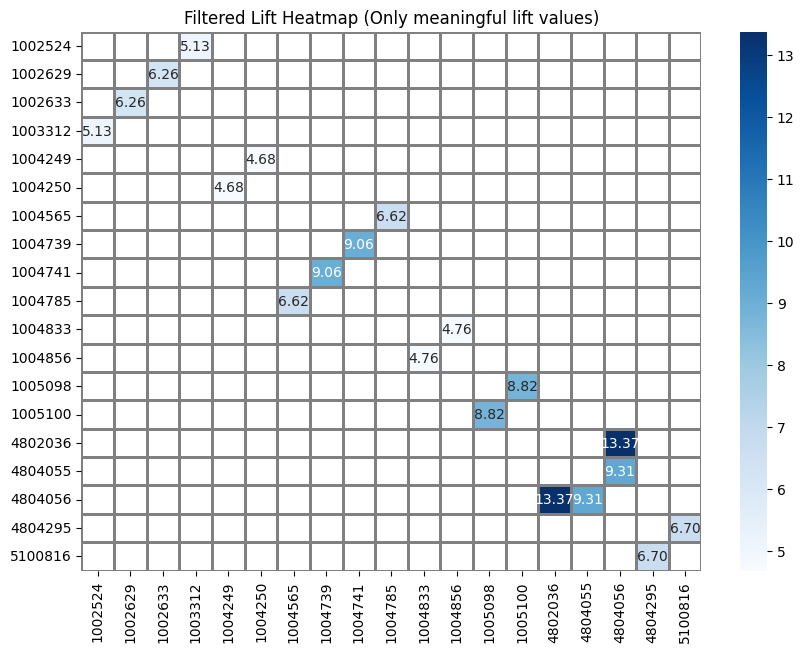

In [25]:
# bỏ ô 0.00
mask = (lift_matrix == 0)

plt.figure(figsize=(10, 7))
sns.heatmap(
    lift_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    mask=mask,               # ẨN Ô 0
    linewidths=1,
    linecolor='gray'
)
plt.title("Filtered Lift Heatmap (Only meaningful lift values)")
plt.show()


### Phân tích hành vi Click 

### Tỷ lệ khách click nhưng không mua

In [29]:
views  = df[df['event_type'] == 'view']['product_id'].nunique()
carts  = df[df['event_type'] == 'cart']['product_id'].nunique()
buys   = df[df['event_type'] == 'purchase']['product_id'].nunique()

print("View → Cart:", carts / views)
print("Cart → Purchase:", buys / carts)
print("View → Purchase:", buys / views)

View → Cart: 0.07053611041164551
Cart → Purchase: 3.590395240118997
View → Purchase: 0.25325251507848007


### TOP sản phẩm được CLICK nhiều nhất

In [30]:
top_click = df[df['event_type']=="view"]['product_id'].value_counts().head(20)
top_click


product_id
1004856    419287
1004767    378777
1005115    327715
1004249    207422
1004833    203018
1005105    197930
1004870    190435
1002544    179249
4804056    179092
5100816    164608
1004741    151176
1004836    143985
1004873    137342
1004739    137295
1005160    132726
1002524    117273
1004785    116315
1002633    109305
1004750    108847
1005100    108469
Name: count, dtype: int64

<Axes: title={'center': 'Top sản phẩm được click nhiều nhất'}, xlabel='product_id'>

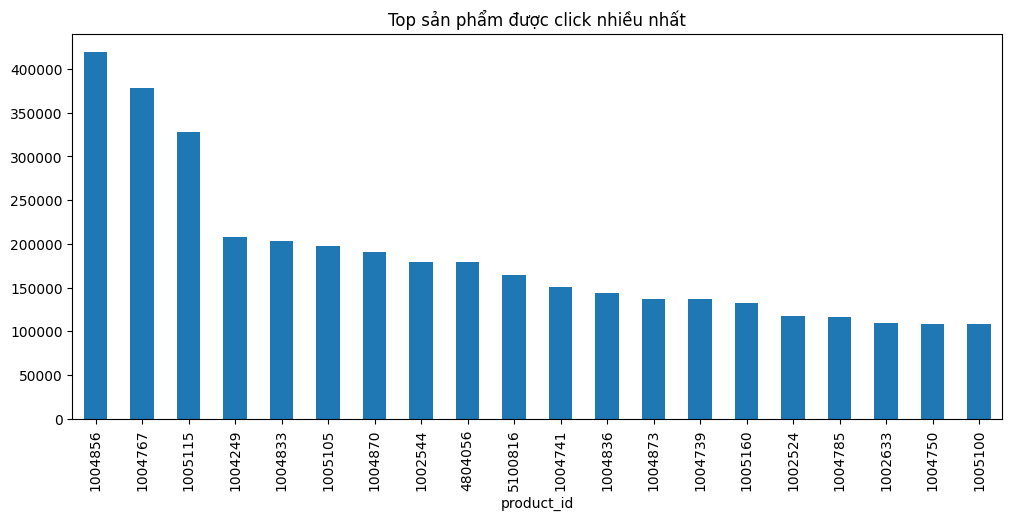

In [31]:
top_click.plot(kind='bar', figsize=(12,5), title="Top sản phẩm được click nhiều nhất")


### Phân tích mức độ hấp dẫn của từng sản phẩm.

In [32]:
views = df[df['event_type']=="view"].groupby("product_id").size()
buys  = df[df['event_type']=="purchase"].groupby("product_id").size()

conversion = (buys / views).fillna(0).sort_values(ascending=False)
conversion.head(20)


product_id
12901176    1.0
26009730    1.0
28102013    1.0
26405067    1.0
21405915    1.0
50300057    1.0
14701426    1.0
26009930    1.0
26001727    1.0
26008004    1.0
12716845    1.0
20500270    1.0
26015297    1.0
26010498    1.0
26009418    1.0
26011573    1.0
26016665    1.0
12720815    1.0
24100063    1.0
26205483    1.0
dtype: float64

<Axes: title={'center': 'Top 20 Conversion Rates'}, ylabel='product_id'>

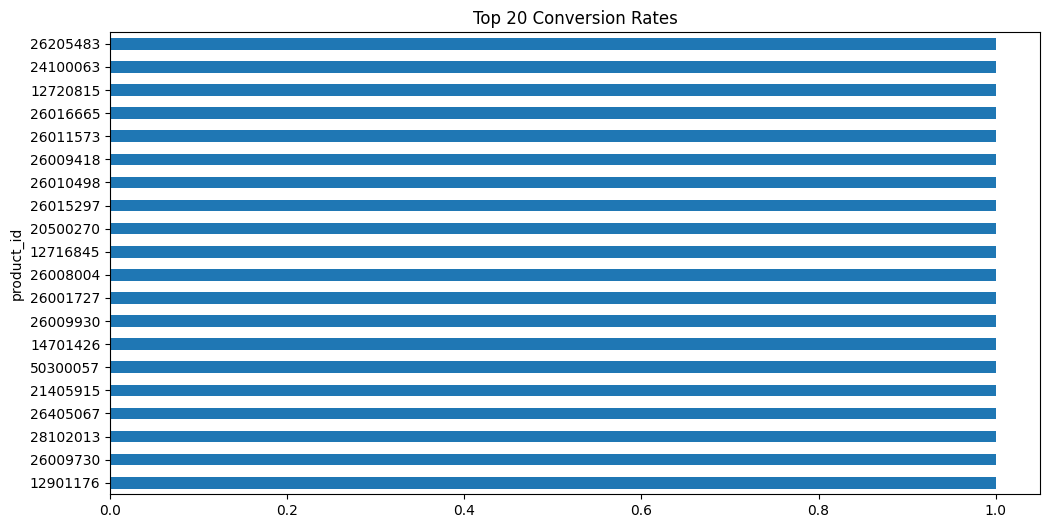

In [33]:
conversion.head(20).plot(kind="barh", figsize=(12,6), title="Top 20 Conversion Rates")

### Phân tích chuỗi hành vi trong session

In [36]:
click_df = df[df['event_type']=="view"]
click_df = click_df.sort_values(["user_session", "event_time"])

click_df["next_click"] = click_df.groupby("user_session")["product_id"].shift(-1)

pairs = click_df.dropna()[["product_id", "next_click"]]
pairs = pairs.value_counts().head(20)
pairs

product_id  next_click
1004856     1004856.0     128240
1004767     1004767.0     119283
1005115     1005115.0      73420
1004870     1004870.0      64926
1004833     1004833.0      58442
4804056     4804056.0      54717
1004741     1004741.0      53350
1004249     1004249.0      50966
1002544     1002544.0      48173
1004739     1004739.0      47619
1005160     1005160.0      47043
1004873     1004873.0      44077
1004836     1004836.0      44065
4804295     4804295.0      43337
1005105     1005105.0      41713
1004785     1004785.0      39037
1004750     1004750.0      33783
1002524     1002524.0      33470
1005115     1005105.0      33257
1004565     1004565.0      32419
Name: count, dtype: int64

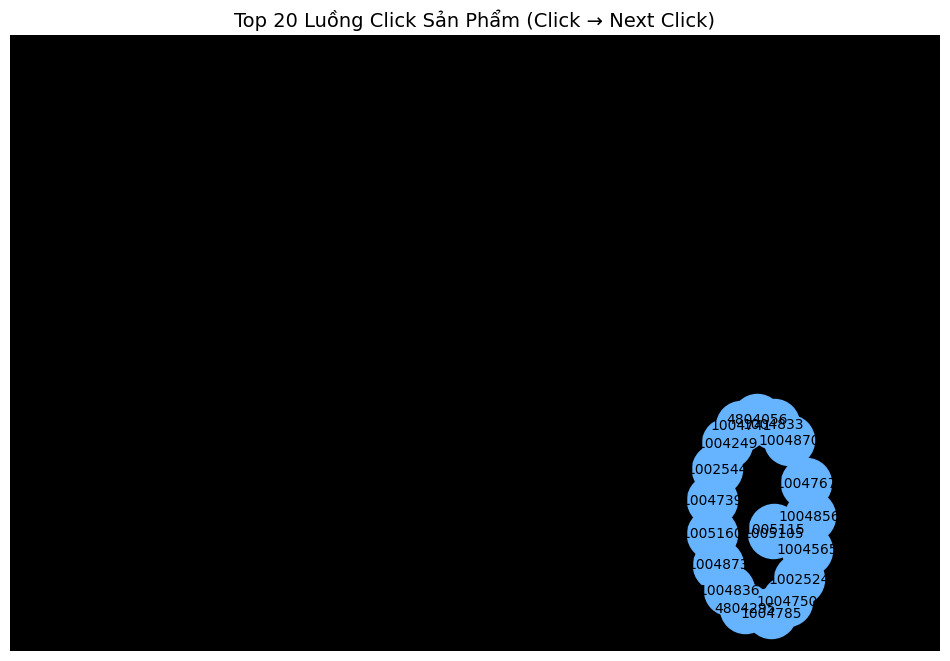

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# Tạo graph có hướng
G = nx.DiGraph()

# Thêm edge với trọng số
for (a, b), count in pairs.items():
    G.add_edge(a, b, weight=count)

# Layout đẹp nhất cho kiểu flow
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=1300, node_color="#66b3ff")

# Edges
nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->", arrowsize=20,
    width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()]  # độ dày theo số lần click
)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Top 20 Luồng Click Sản Phẩm (Click → Next Click)", fontsize=14)
plt.axis("off")
plt.show()


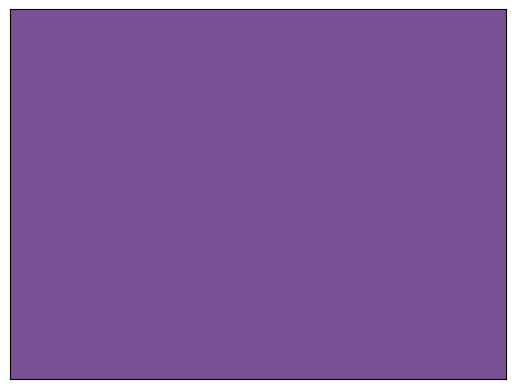

In [ ]:
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_w = max(weights)

colors = ["#003f5c" if G[u][v]['weight'] == max_w else "#7a5195" for u,v in G.edges()]

nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->",
    arrowsize=18,
    width=[w*0.1 for w in weights],
    edge_color=colors
)


### phân tích hành vi VIEW-TO-VIEW

In [40]:
# CLICK DATA: Lấy top 200 sản phẩm → không bị MemoryError
view_df = df[df["event_type"]=="view"].copy()
view_df["product_id"] = view_df["product_id"].astype(str)

top_products = view_df["product_id"].value_counts().head(200).index
view_df = view_df[view_df["product_id"].isin(top_products)]

# Lọc session có >= 2 click
session_counts = view_df.groupby("user_session")["product_id"].nunique()
valid = session_counts[session_counts > 1].index
view_df = view_df[view_df["user_session"].isin(valid)]

# Lấy 20k session
sample_sessions = view_df["user_session"].unique()[:20000]
sample_view = view_df[view_df["user_session"].isin(sample_sessions)]

# Basket
basket = (sample_view
          .groupby(["user_session", "product_id"])["event_type"]
          .count().unstack().fillna(0))
basket = (basket > 0).astype(bool)

# FP-Growth
from mlxtend.frequent_patterns import fpgrowth, association_rules

fi = fpgrowth(basket, min_support=0.002, use_colnames=True)
rules_click = association_rules(fi, metric="lift", min_threshold=1.1)

rules_click = rules_click.sort_values("lift", ascending=False)
rules_click.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1590,(3701134),(3700926),0.00430,0.00475,0.00290,0.674419,141.982864,1.0,0.002880,3.056839,0.997245,0.471545,0.672865,0.642472
1591,(3700926),(3701134),0.00475,0.00430,0.00290,0.610526,141.982864,1.0,0.002880,2.556527,0.997696,0.471545,0.608844,0.642472
1185,(1307073),(1307187),0.00720,0.00330,0.00225,0.312500,94.696970,1.0,0.002226,1.449745,0.996616,0.272727,0.310224,0.497159
1184,(1307187),(1307073),0.00330,0.00720,0.00225,0.681818,94.696970,1.0,0.002226,3.120229,0.992716,0.272727,0.679511,0.497159
1618,(1307074),(1307073),0.00515,0.00720,0.00325,0.631068,87.648328,1.0,0.003213,2.691011,0.993708,0.357143,0.628392,0.541228


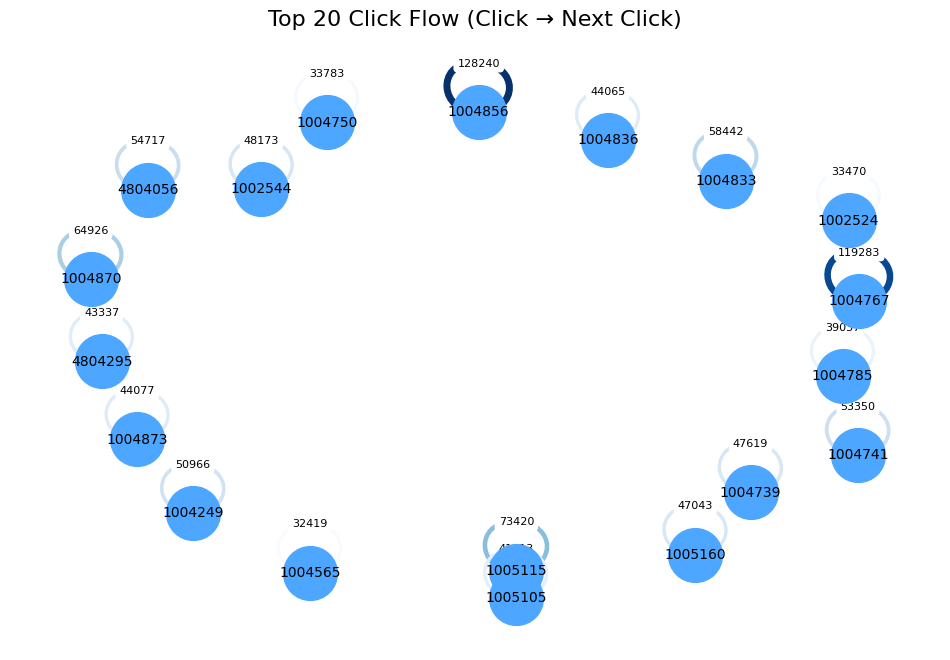

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Tạo graph
G = nx.DiGraph()
for (a, b), w in pairs.items():
    G.add_edge(a, b, weight=w)

# Layout đẹp dạng “flow”
pos = nx.spring_layout(G, k=1.5, seed=42)

plt.figure(figsize=(12, 8))

# Lấy trọng số để tô màu
weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
norm = plt.Normalize(weights.min(), weights.max())
colors = cm.Blues(norm(weights))

# Vẽ node
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="#4DA6FF")

# Vẽ edge có MÀU + ĐỘ DÀY + MŨI TÊN
nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->", arrowsize=18,
    width=weights / weights.max() * 4 + 1,
    edge_color=colors
)

# Node label
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge label (số lần click)
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Top 20 Click Flow (Click → Next Click)", fontsize=16)
plt.axis("off")
plt.show()


#### HeatMap click

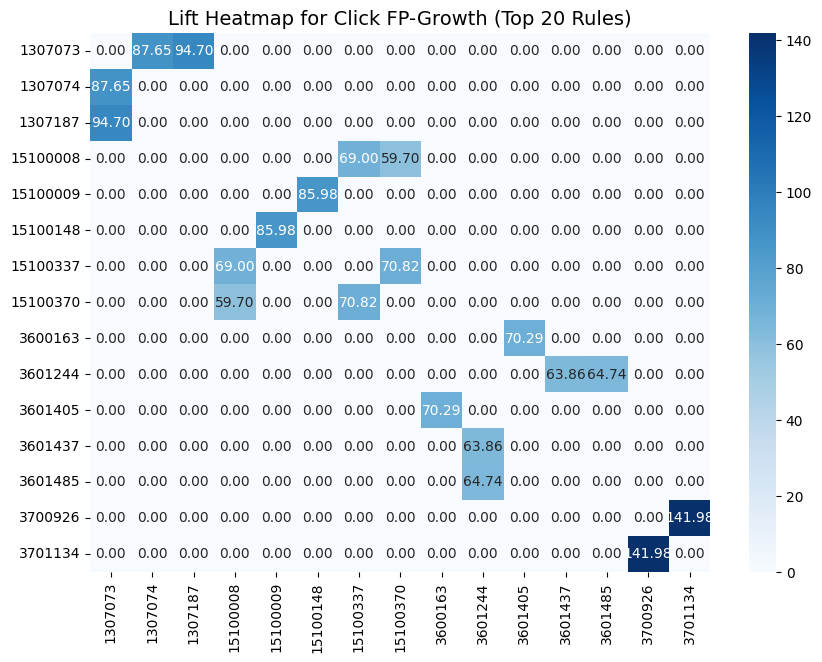

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Lấy top 20 luật click
top_rules = rules_click.head(20)

items = sorted(list(
    set(top_rules['antecedents'].apply(lambda x: list(x)[0])) |
    set(top_rules['consequents'].apply(lambda x: list(x)[0]))
))

# Tạo ma trận lift
lift_matrix = pd.DataFrame(0.0, index=items, columns=items, dtype=float)
for _, r in top_rules.iterrows():
    a = list(r["antecedents"])[0]
    c = list(r["consequents"])[0]
    lift_matrix.loc[a, c] = r["lift"]

plt.figure(figsize=(10, 7))
sns.heatmap(lift_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Lift Heatmap for Click FP-Growth (Top 20 Rules)", fontsize=14)
plt.show()


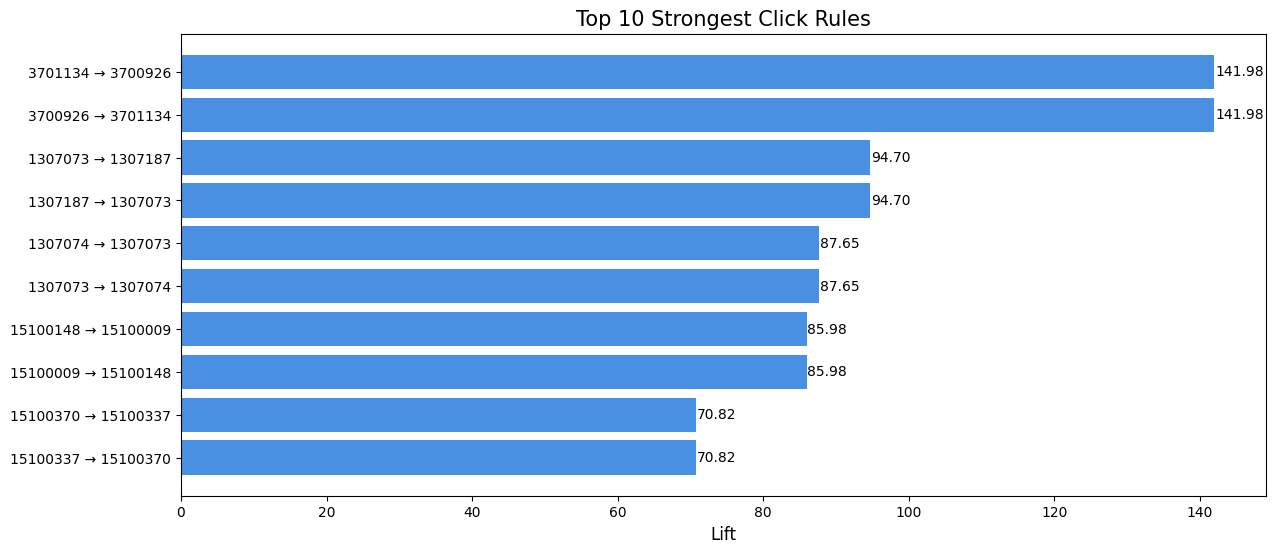

In [45]:
top10 = rules_click.head(10).copy()

# Chuyển frozenset thành string
def fs_to_str(fs):
    return ", ".join(list(fs))

top10["label"] = top10.apply(
    lambda r: f"{fs_to_str(r['antecedents'])} → {fs_to_str(r['consequents'])}",
    axis=1
)

plt.figure(figsize=(14, 6))
plt.barh(top10["label"], top10["lift"], color="#4a90e2")

plt.xlabel("Lift", fontsize=12)
plt.title("Top 10 Strongest Click Rules", fontsize=15)
plt.gca().invert_yaxis()

# hiển thị lift ở cuối từng thanh
for i, v in enumerate(top10["lift"]):
    plt.text(v + 0.1, i, f"{v:.2f}", va='center')

plt.show()


### Phân cụm khách hàng 

### Tạo RFM table

In [46]:
import pandas as pd
import numpy as np

# chỉ lấy purchase
purchase_df = df[df["event_type"] == "purchase"].copy()
purchase_df["event_time"] = pd.to_datetime(purchase_df["event_time"])

# snapshot date = ngày lớn nhất + 1
snapshot_date = purchase_df["event_time"].max() + pd.Timedelta(days=1)

# RFM
rfm = purchase_df.groupby("user_id").agg({
    "event_time": lambda x: (snapshot_date - x.max()).days,   # Recency
    "user_session": "count",                                   # Frequency
    "price": "sum"                                              # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
user_id,,,
264649825,26,2,1240.04
303160429,19,1,340.59
340041246,18,4,915.52
371877401,23,1,29.89
384989212,14,1,41.44


### CHUẨN HÓA & PHÂN CỤM

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

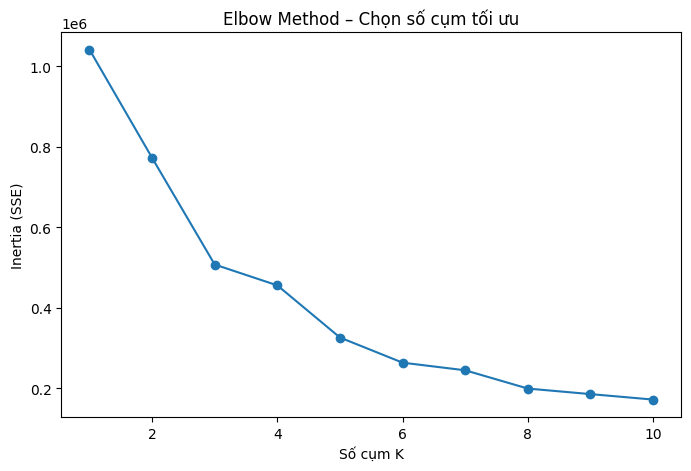

In [48]:
#TÌM SỐ CỤM TỐI ƯU BẰNG ĐỊNH LÝ KHUỶU TAY (Elbow Method)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker="o")
plt.xlabel("Số cụm K")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method – Chọn số cụm tối ưu")
plt.show()


In [49]:
# ÁP DỤNG K-MEANS VỚI SỐ CỤM TỐI ƯU
k_optimal = 4  # thay tùy theo kết quả elbow method

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm["cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,cluster
user_id,,,,
264649825,26,2,1240.04,1
303160429,19,1,340.59,3
340041246,18,4,915.52,3
371877401,23,1,29.89,1
384989212,14,1,41.44,3


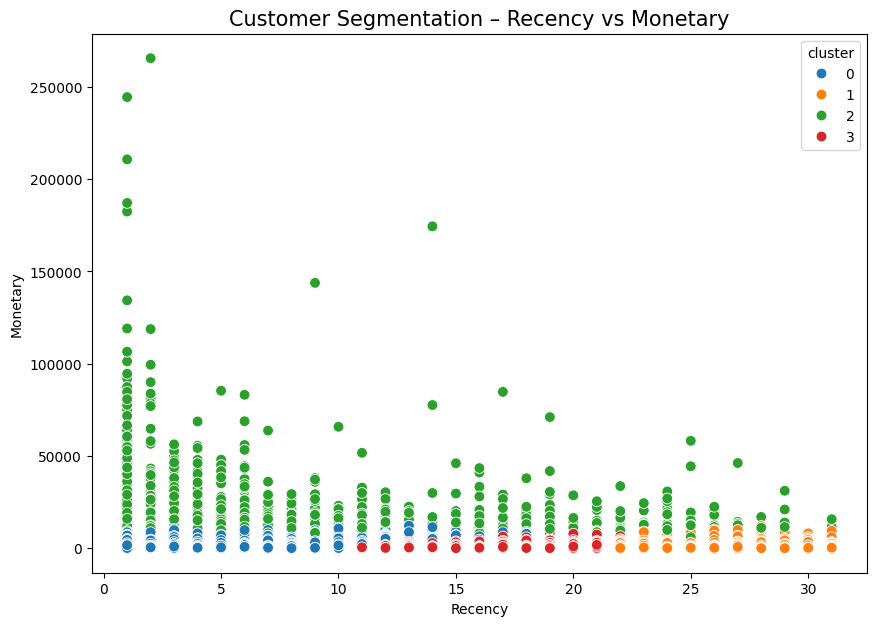

In [50]:
# Recency–Monetary
import seaborn as sns

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="cluster",
    palette="tab10",
    s=60
)
plt.title("Customer Segmentation – Recency vs Monetary", fontsize=15)
plt.show()

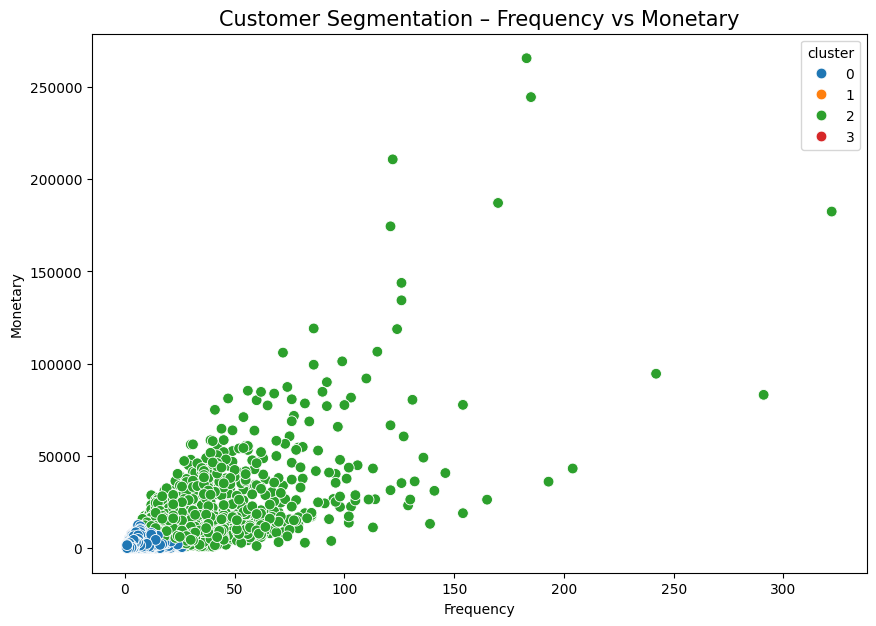

In [51]:
# Frequency–Monetary.
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=rfm,
    x="Frequency",
    y="Monetary",
    hue="cluster",
    palette="tab10",
    s=60
)
plt.title("Customer Segmentation – Frequency vs Monetary", fontsize=15)
plt.show()


### BAR CHART TOP SẢN PHẨM THEO CỤM

Cluster 1


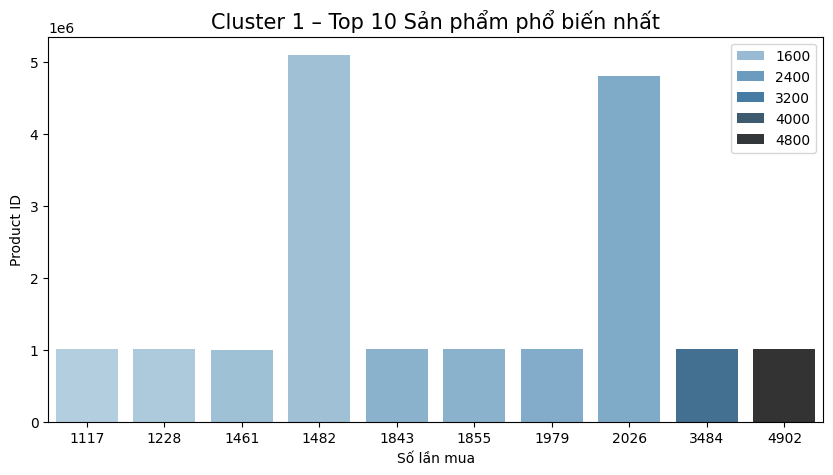

Cluster 3


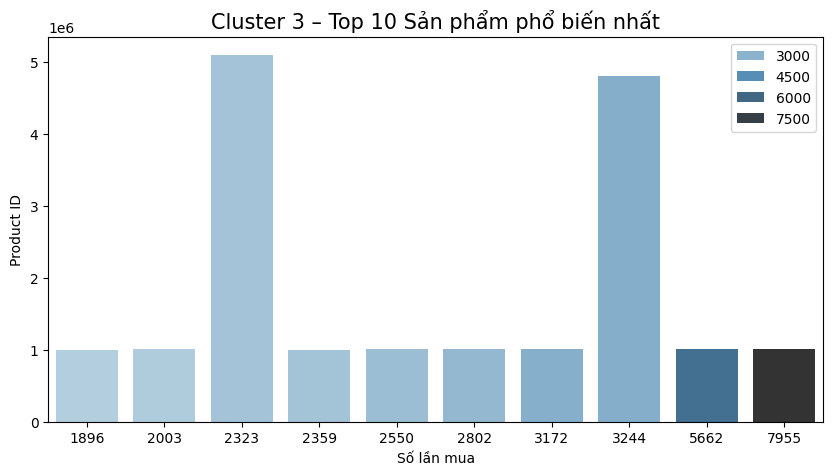

Cluster 0


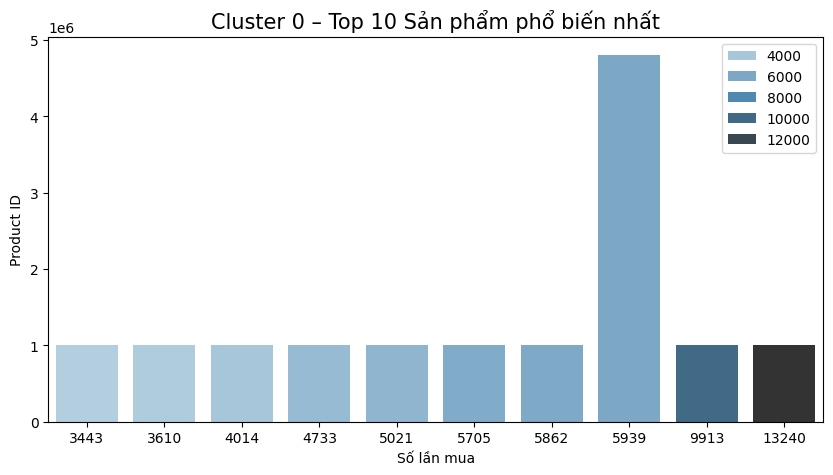

Cluster 2


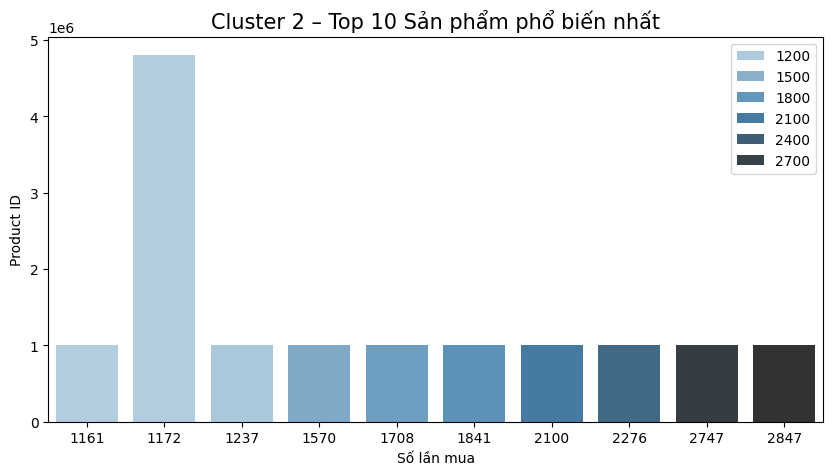

In [59]:
for c in rfm["cluster"].unique():
    print(f"Cluster {c}")
    
    users = rfm[rfm["cluster"] == c].index
    subset = df[(df["user_id"].isin(users)) & (df["event_type"]=="purchase")]

    top_items = subset["product_id"].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_items.values, y=top_items.index, palette="Blues_d", hue=top_items.values)
    plt.title(f"Cluster {c} – Top 10 Sản phẩm phổ biến nhất", fontsize=15)
    plt.xlabel("Số lần mua")
    plt.ylabel("Product ID")
    plt.show()


In [60]:
# HEATMAP LUẬT THEO TỪNG CỤM
from mlxtend.frequent_patterns import fpgrowth, association_rules

rules_per_cluster = {}

for c in rfm["cluster"].unique():
    print(f"\nCluster {c}")

    users = rfm[rfm["cluster"] == c].index
    subset = df[(df["user_id"].isin(users)) & (df["event_type"]=="purchase")]

    # Chỉ lấy top 200 sản phẩm trong cluster
    top_products = subset["product_id"].value_counts().head(200).index
    subset = subset[subset["product_id"].isin(top_products)]

    # Lọc session có >= 2 sp
    session_counts = subset.groupby("user_session")["product_id"].nunique()
    valid = session_counts[session_counts > 1].index
    subset = subset[subset["user_session"].isin(valid)]

    # Giới hạn session
    subset = subset[subset["user_session"].isin(subset["user_session"].unique()[:20000])]
    subset["product_id"] = subset["product_id"].astype(str)

    # Basket
    basket = (subset.groupby(["user_session","product_id"])["event_type"]
              .count().unstack().fillna(0))
    basket = (basket > 0).astype(bool)

    fi = fpgrowth(basket, min_support=0.005, use_colnames=True)
    rules = association_rules(fi, metric="lift", min_threshold=1.2)

    rules_per_cluster[c] = rules
    print("Rules:", len(rules))



Cluster 1
Rules: 40

Cluster 3
Rules: 34

Cluster 0
Rules: 42

Cluster 2
Rules: 72


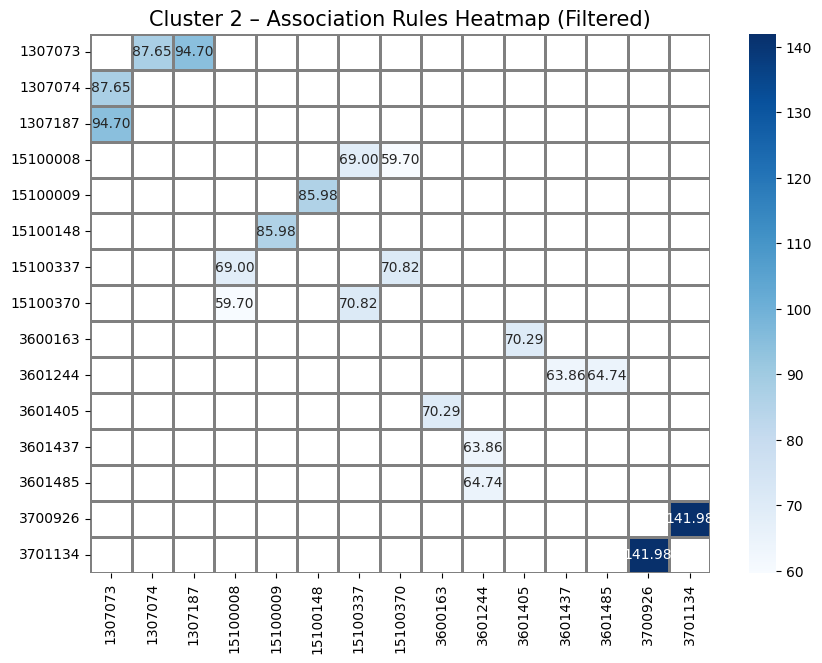

In [61]:
mask = (lift_matrix == 0)

plt.figure(figsize=(10,7))
sns.heatmap(
    lift_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    mask=mask,               # CHE Ô 0
    linewidths=1,
    linecolor="gray",
    cbar=True
)
plt.title(f"Cluster {c} – Association Rules Heatmap (Filtered)", fontsize=15)
plt.show()
